In [1]:
import os
import re
import sys
import math
import time
import queue
import random
import shutil
import logging
import operator
import threading
import numpy as np
import matplotlib.pyplot as plt
from typing import TypeAlias, Iterator, Generator, Union, NamedTuple

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalizes to [-1, 1]
])
# Load CIFAR-10 datasets
dataset_path = r"F:\deep_experiments\datasets\CIFAR10_data"
train_dataset = datasets.CIFAR10(root=dataset_path, train=True, download=False, transform=transform)
test_dataset = datasets.CIFAR10(root=dataset_path, train=False, download=False, transform=transform)

# # Combine train and test datasets
# full_dataset = train_dataset + test_dataset

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

n_classes = 10

$$\text{Scaled Dot Product Attention} = \text{softmax}(\dfrac {KQ^T}{\sqrt{d_{kq}}}) V$$


In [3]:
patch_shape: TypeAlias = tuple[int, int, int]

# TODO: Add positional encoding
# THOUGHT: may be able to implement using conv, with no over lapping (step adjustment)
class EmbedImage(nn.Module):
    def __init__(self, patch_shape:patch_shape, num_embeddings:int, embedding_dim:int) -> None:
        super().__init__()
        self.patch_shape = patch_shape
        patch_size = 1
        for a in patch_shape: patch_size *= a
        self.embed_proj = nn.Linear(patch_size, num_embeddings * embedding_dim, bias=False) # (P_s, N * E)
        self.ALPE = nn.Parameter(torch.rand(8, 8, 1, embedding_dim)) # absolute learnable pos encoding
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        ph, pw, _ = self.patch_shape
        B, H, W, C = x.shape # (Batch, Hight, Width, Chanels)
        patches = x.unfold(1, ph, ph).unfold(2, pw, pw)
        patches_flatten = patches.flatten(3, -1)
        out: torch.Tensor = self.embed_proj(patches_flatten)
        out = out.view(B, H//ph, W//pw, self.num_embeddings, self.embedding_dim) + self.ALPE # (B, h, w, N, E)
        return out # (Batch, hight of grid, width of grid, num embeddings, embedding dim)


class GLU(nn.Module):
    """Gated Linear Unit variant: Sigmoid(W_gate*x) * (W_transform*x)."""
    def __init__(self, in_features: int, hidden_features: int, out_features: int, bias: bool = False):
        super().__init__()
        # Linear layer for gate and value, then split. hidden_features is for each branch before *
        self.fc_gate_value = nn.Linear(in_features, 2 * hidden_features, bias=bias)
        self.fc_out = nn.Linear(hidden_features, out_features, bias=bias)
        self.dropout = nn.Dropout(.5)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        gate_val_proj = self.fc_gate_value(x)
        # Split into two parts: one for the gate, one for the value
        gated_values, gate_input = torch.split(gate_val_proj, gate_val_proj.shape[-1] // 2, dim=-1)

        gated_activation = self.dropout(self.sigmoid(gated_values) * gate_input) # Element-wise product
        out = self.fc_out(gated_activation)
        return out


class FusedMultiHeadAttention_linear(nn.Module):
    """Fused Multi Head Attention via linear layers"""
    def __init__(self, embedding_dim:int, num_heads:int, KQ_dim:int|None=None, V_dim:int|None=None):
        super().__init__()
        self.num_heads = num_heads
        self.KQ_dim = embedding_dim // num_heads if KQ_dim is None else KQ_dim
        self.V_dim = embedding_dim // num_heads if V_dim is None else V_dim
        self.weights = nn.Linear(embedding_dim, num_heads * (2*self.KQ_dim + self.V_dim), bias=False)
        self.project = nn.Linear(self.V_dim * self.num_heads, embedding_dim, bias=False)

    def forward(self, x_in:torch.Tensor) -> torch.Tensor:
        residual = x_in
        Qs, Ks, Vs = torch.split(self.weights(x_in), [*[self.num_heads * self.KQ_dim] * 2, self.num_heads * self.V_dim], -1)
        Qs, Ks, Vs = [torch.chunk(M, self.num_heads, -1) for M in (Qs, Ks, Vs)]

        # TODO: Do parallel via einsum et al.
        attend = torch.cat([self.scaled_dot_product_softmax(q, k, v, self.KQ_dim) for q, k, v in zip(Qs, Ks, Vs)], dim=-1)
        out = self.project(attend) + residual
        return out

    @staticmethod
    def scaled_dot_product_softmax(q:torch.Tensor, k:torch.Tensor, v:torch.Tensor, kq_dim:int) -> torch.Tensor:
        """
        Scaled dot product softmax attention.

        $$\text{scaled dot product attention} = \text{softmax}(\dfrac {KQ^T}{\sqrt{d_{kq}}}) V$$

        """
        energies = torch.softmax((q @ k.transpose(-2, -1)) * kq_dim**-.5, dim=-1)
        out = energies @ v
        return out


class ViT(nn.Module):
    def __init__(
            self, 
            embedding_dim:int, 
            num_embeddings:int, 
            num_conv_chanels:int, 
            patch_shape:patch_shape, 
            num_heads:int, 
            n_blocks:int, 
            KQ_dim:int|None=None, 
            V_dim:int|None=None
            ) -> None:
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, num_conv_chanels, kernel_size=(4, 4), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=1, padding=1),
            nn.Conv2d(num_conv_chanels, num_conv_chanels, kernel_size=(4, 4), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 2), stride=1, padding=1),
            nn.Conv2d(num_conv_chanels, num_conv_chanels, kernel_size=(4, 4), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(num_conv_chanels, num_conv_chanels, kernel_size=(4, 4), stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 2))
        )

        self.embed = EmbedImage(patch_shape, num_embeddings, embedding_dim)
        self.cls_token = nn.Parameter(torch.rand(embedding_dim,))
        transformer_block_A = lambda: nn.Sequential(
            FusedMultiHeadAttention_linear(embedding_dim, num_heads, KQ_dim, V_dim), 
            nn.LayerNorm(embedding_dim), 
            GLU(embedding_dim, embedding_dim*2, embedding_dim)
        )
        transformer_block_B = lambda: nn.Sequential(
            FusedMultiHeadAttention_linear(embedding_dim, num_heads, KQ_dim, V_dim), 
            nn.LayerNorm(embedding_dim), 
            GLU(embedding_dim, embedding_dim*2, embedding_dim)
        )
        self.blocks_0 = nn.ModuleList([transformer_block_A() for _ in range(n_blocks)])
        self.blocks_1 = nn.ModuleList([transformer_block_B() for _ in range(n_blocks)])
        
        self.decode = nn.Linear(embedding_dim, n_classes)

    def forward(self, image:torch.Tensor) -> torch.Tensor:
        out = self.conv_block(image)
        out = self.embed(out.moveaxis(1, -1))
        for block in self.blocks_0: out: torch.Tensor = block(out)
        out = out.mean(-2)
        B, h, w, e = out.shape
        cls = self.cls_token[None].expand((B, 1, e))
        out = torch.cat([out.view(B, h*w, e), cls], -2)
        for block in self.blocks_1: out: torch.Tensor = block(out)
        out = self.decode(out[:, -1])
        return out

# TODO: attetion -> MHA -> GLU -> cross embedding Block -> 
# TODO for later: do convolution before embedding the images
# TODO implement local-global attention mechanism

In [4]:
augment_p = .5
identity_p = 1.0 - augment_p
noise_p, color_channel_flip_p, k_means_clustering_p = [p * augment_p for p in (.8, .15, .05)]
noise_type_probabilities = {
    "normal_noise_p": .7,
    "uniform_noise_p": .2,
    "bernoulli_mask_p": .1}
augment_type_probabilities = {k: round(v * noise_p, 5) for k, v in noise_type_probabilities.items()}
augment_type_probabilities.update({
    'identity': identity_p, 
    'color_channel_flip_p': color_channel_flip_p,
    'k_means_clustering_p': k_means_clustering_p})

# BUG: Not exactly a bug but the bellow code assumes batched image input and (B, C, H, W) arrangements

def color_channel_flip(image:torch.Tensor) -> torch.Tensor:
    return image[:, np.random.permutation(3).tolist()]

def bernoulli_mask(image:torch.Tensor) -> torch.Tensor:
    mask = torch.bernoulli(torch.empty(image.shape).uniform_(0, 1), .8).to(image.device)
    # Three ways of doing it: torch.where(mask == 0, 0, x) or mask * image or torch.dropout(image, .8, train=True)
    out = torch.where(mask != 0, image, 0)
    return out

def flip_image(image:torch.Tensor) -> torch.Tensor:
    if isinstance(image, torch.Tensor): return torch.flip(image, [3])
    elif isinstance(image, np.ndarray): return image[:, :, :, ::-1]

@torch.no_grad()
def get_augment_class(image:torch.Tensor, probabilities:dict):
    p_sum = sum(probabilities.values())
    assert p_sum == 1.0, f"`probabilities` must sum to 1.0, instead sum to {p_sum}."
    assert image.ndim == 3 or 4, "The image ndim is assumed to be 3 or 4 (H, W, C) or (B, H, W, C). Channels maybe different."
    probabilities_list = [(k, v) for k, v in probabilities.items()]
    class_index = np.random.choice(len(probabilities), p=np.array(list(probabilities.values())))
    out_type = probabilities_list[class_index][0]
    if   out_type == 'identity': return flip_image(image) if random.randint(0, 1) else image
    elif out_type == 'normal_noise_p': return .94 * image + .06 * torch.randn(image.shape).to(image.device)
    elif out_type == 'uniform_noise_p': return .94 * image + .06 * torch.rand(image.shape).to(image.device)
    elif out_type == 'bernoulli_mask_p': return bernoulli_mask(image)
    elif out_type == 'color_channel_flip_p': return color_channel_flip(image)
    # TODO: for this write values to disk or pre compute centeroid values (do kmc for a subset of the dataset, take centeroid mean).
    elif out_type == 'k_means_clustering_p': return image
    else: raise ValueError # Raise some error

In [5]:
def cos_anneal_lr_scheduler_gen(
    warmup_steps: int, total_anneal_steps: int, 
    lr_at_warmup_start: float, lr_at_cosine_start: float, lr_at_cosine_end: float
) -> Iterator[float]:
    """
    Generates learning rates: linear warmup then cosine annealing.  
    Note: total_anneal_steps is total_steps - warmup_steps
    """

    # Linear warmup phase
    for step in range(warmup_steps):
        progress = (step + 1) / warmup_steps
        current_lr = lr_at_warmup_start + progress * (lr_at_cosine_start - lr_at_warmup_start)
        yield current_lr

    # Cosine annealing phase
    for step in range(total_anneal_steps):
        cos_inner = math.pi * step / total_anneal_steps
        current_lr = lr_at_cosine_end + 0.5 * (lr_at_cosine_start - lr_at_cosine_end) * (1 + math.cos(cos_inner))
        yield current_lr

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on matmul
torch.backends.cudnn.allow_tf32 = True  # Allow TF32 on cudnn
torch.backends.cudnn.benchmark = True  # Enable cudnn autotuner
torch._C._jit_set_profiling_executor(True)
torch._C._jit_set_profiling_mode(True)

@torch.jit.script
def fast_cross_entropy(logits, targets):
    return F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))

embedding_dim = 32
num_embeddings = 4
num_conv_chanels = 16
patch_shapes = (4, 4, num_conv_chanels)
num_heads = 4
n_blocks = 3
KQ_dim = 12
V_dim = 16

model = ViT(embedding_dim, num_embeddings, num_conv_chanels, patch_shapes, num_heads, n_blocks, KQ_dim, V_dim)
model.to(device)

num_batches = len(train_loader)
parameter_count = sum([p.nelement() for p in list(model.parameters())])
print(f"number of parameters : {parameter_count:,}")
expected_untrained_loss = -math.log(1/n_classes)
print(f"expected untrained loss: {expected_untrained_loss:.4f}")

NUM_EPOCHS = 24

total_optim_steps = num_batches * NUM_EPOCHS
warmup_steps = int(.1 * total_optim_steps)
total_anneal_steps = total_optim_steps - warmup_steps
lr_at_warmup_start = 5e-4
lr_at_cosine_start = 2e-3
lr_at_cosine_end = 1e-4

lr_scheduler = cos_anneal_lr_scheduler_gen(
    warmup_steps=warmup_steps, 
    total_anneal_steps=total_anneal_steps,
    lr_at_warmup_start=lr_at_warmup_start, 
    lr_at_cosine_start=lr_at_cosine_start, 
    lr_at_cosine_end=lr_at_cosine_end
)

loss_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_at_warmup_start, weight_decay=0.01)

logger = logging.getLogger('ViT_train_info')
logging.basicConfig(filename=f'ViT_train_info.log', level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s', encoding='utf-8')

class History(NamedTuple):
    loss: list[float, ...]|None = []
    accuracy: list[float, ...]|None = []
    class_probability: list[float, ...]|None = []
    performance: list[float, ...]|None = []
    LR: list[float, ...]|None = []

    def __call__(self, snapshot: tuple[float, ...]) -> None:
        for ann, snap in zip(self.__annotations__, snapshot):
            self.__getattribute__(ann).append(snap)

history = History()
history.__annotations__

number of parameters : 128,554
expected untrained loss: 2.3026


{'loss': list[float, ...] | None,
 'accuracy': list[float, ...] | None,
 'class_probability': list[float, ...] | None,
 'performance': list[float, ...] | None,
 'LR': list[float, ...] | None}

In [7]:
@torch.no_grad()
def accuracy(logits:torch.Tensor, targets:torch.Tensor):
    return (logits.argmax(-1) == targets).to(torch.float32).mean().item()

def train(
        batch: list[torch.Tensor, torch.Tensor], 
        model: ViT, criterion: nn.CrossEntropyLoss, 
        optimizer: torch.optim.AdamW, 
        lr_scheduler: Union[Generator, Iterator]
        ):
    model.train()
    lr: float = next(lr_scheduler)
    for param_group in optimizer.param_groups: param_group['lr'] = lr
    inputs, targets = batch
    inputs, targets = get_augment_class(inputs.to(device), augment_type_probabilities), targets.to(device)
    
    optimizer.zero_grad()
    logits = model(inputs)
    loss = criterion(logits.view(-1, logits.size(-1)), targets.view(-1))
    acc = accuracy(logits, targets)
    loss.backward()
    optimizer.step()
    return loss.item(), acc, lr

In [8]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, batch in enumerate(train_loader):
        loss, acc, lr = train(batch, model, loss_criterion, optimizer, lr_scheduler)
        class_prob = math.exp(-loss) # can be considered "confidence"
        performance = class_prob * acc * 1e4
        history((loss, acc, class_prob, performance, lr))
        reports = [
            f"\repoch: {round(epoch + batch_idx/num_batches, 2):2.2f} / {NUM_EPOCHS}", 
            f"loss: {loss:.4f} -- accuracy: {round(acc, 4):.4f}", 
            f"class probability: {round(class_prob, 4):.4f}", 
            f"performance: {round(performance, 4):4.4f}"
        ]
        print(*reports, sep=' -- ', end='', flush=True)
        if batch_idx % 10 == 0: logger.info(" -- ".join(reports))

epoch: 23.99 / 24 -- loss: 1.1882 -- accuracy: 0.5863 -- class probability: 0.3048 -- performance: 1786.8810

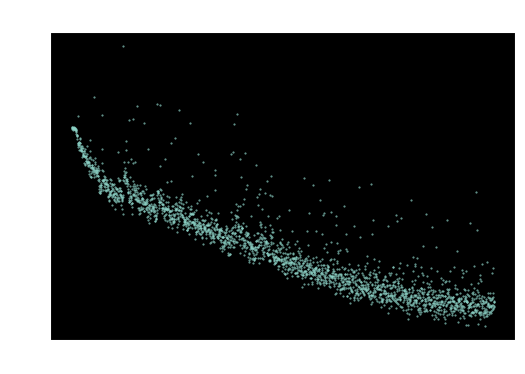

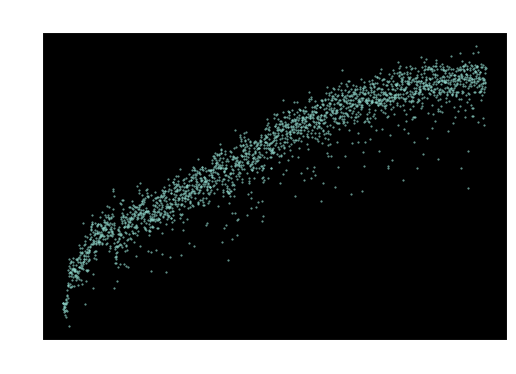

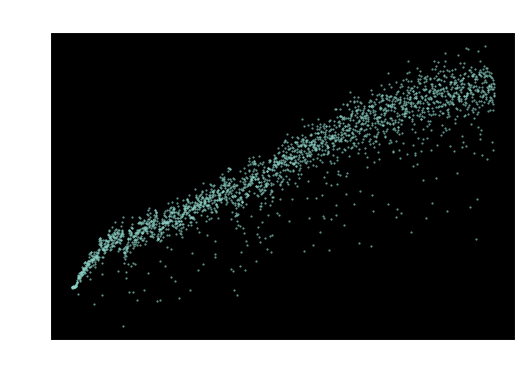

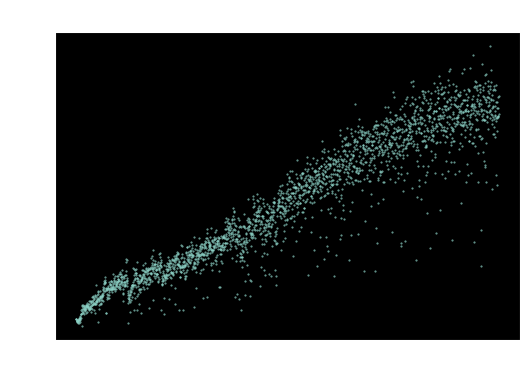

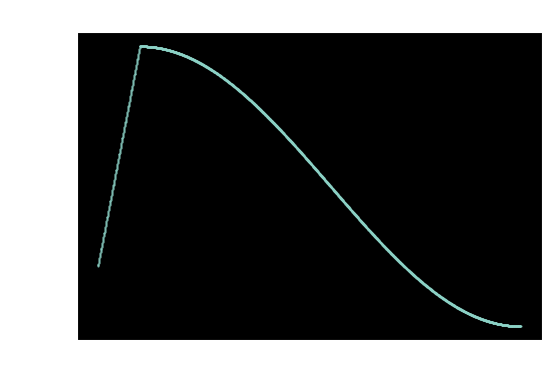

In [9]:
def plot(k:str):
    plt.figure(figsize=(6, 4), frameon=False)
    plt.plot(history.__getattribute__(k), '.', alpha=.8, ms=1)
    plt.title(k.replace('_', ' ').capitalize())
    plt.show()

for k in history.__annotations__:
    plot(k)